In [2]:
#This Cell Defines the parameters
import time
import cPickle as pickle
#import cv2
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy.integrate import RK45
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.linear_model import LinearRegression

#Parameters
eta = 1.0					#Dispersion Parameter
n = 36						#Number of x-components
x_0 = np.zeros(n)			#Initial x
#x_0[0] = 0.99 
v_0 = x_0 					#v = x * (Integrating Factor). In this case IF = exp(eta*t), so IF(0) = 1 
sigma = 0.5					#SD of noise
S = np.zeros((n,n))			#covariance matrix for the noise
for i in xrange(5):
	S[i][i] = sigma 
h = 0.005					#Time step
h_range = np.arange(0.005, 0.025, 0.005)
t_final = 20.				#Terminal simulation time
nsteps = int(t_final / h)	#Number of steps
l = 0.8						#mixing parameter for the stratification algorithm
#Setup of Stratification
strata = [[-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75], [-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75]] 		#Boundary points of the strata in x_0 (or also later coordinates)
nu_0_weights = 1. / (len(strata) + 1.) * np.ones(len(strata) + 1)
n_exits = 20
n_iterations = 50
bin_edges = np.arange(-1., 1., 0.025)
bin_edges_later_vars = np.arange(-.3, .3, 0.0075)  #'later vars' refers to x_1,...,x_n. only x_0 has a direct source of noise, so the range it explores is different
bin_diff = 0.025
bin_diff_later_vars = 0.0075

J = (len(strata[0]) + 1)**2
#Initialize the collection of injection measures and weights
#The initial nu is a single point in each region, with weight 1
nu_0_points = []
nu_0_probs = []
K = len(strata[0]) + 1
for i in xrange(K-1):
    for j in xrange(K-1): 
        y = np.zeros(n)
        y[0] = strata[0][i] - 0.1
        y[4] = strata[1][j] - 0.1
        nu_0_points.append([y])
        nu_0_probs.append([1.])
    y = np.zeros(n)
    y[0] = strata[0][i] - 0.1
    y[4] = strata[1][K-2] + 0.1
    nu_0_points.append([y])
    nu_0_probs.append([1.])
for j in xrange(K-1): 
    y = np.zeros(n)
    y[0] = strata[0][K-2] + 0.1
    y[4] = strata[1][j] - 0.1
    nu_0_points.append([y])
    nu_0_probs.append([1.])
y = np.zeros(n)
y[0] = strata[0][K-2] + 0.1
y[4] = strata[1][K-2] + 0.1
nu_0_points.append([y])
nu_0_probs.append([1.])


In [87]:
#This Cell contains Definitions of the main functions
def f_IFRK(y, t):
    d = np.zeros(n)
    d[0] = (y[1] - y[n-2]) * y[n-1] + 4 * y[0] - 16 * (y[0]*y[0]*y[0]) #RK4 function for a double well in 2 coordinates
    d[1] = (y[2] - y[n-1]) * y[0] - y[1]
    d[n-1] = (y[0] - y[n-3]) * y[n-2] - y[n-1]
    for i in range(2, n-1):
        d[i] = (y[i+1] - y[i-2]) * y[i-1] - y[i]
    d[4] = (y[5] - y[2]) * y[3] + 4 * y[4] - 16 * (y[4]*y[4]*y[4])
    return d

def g_IFRK(y, t): 
	noise = np.zeros(n)
	for i in xrange(n):
		noise[i] = S[i][i] * np.exp(eta * t)
	return noise


#The function that moves a stochastic system dX = fdt + gdW ahead by time h via Runge-Kutta
def RK_SDE_Step(y, t, f, g, h): 
	m = len(y)
	dW = np.random.normal(0.0, np.sqrt(h), m)
	b = np.random.binomial(1, 0.5)	#The binary RV used in the improved Euler RK method for sde's
	if b == 0:
		b = -1
	K_1 = h * f(y, t) + (dW - np.sqrt(h) * b) * g(y, t) 
	K_2 = h * f(y + K_1, t + h) + (dW + np.sqrt(h)*b) * g(y + K_1, t + h)
	y_new = y + 0.5 * (K_1 + K_2) 
	return y_new

#The Function that evolves the deterministic part of an SDE only by time h using RK4
def RK_4_Step(y, t, f, h):
	K_1 = h * f(y, t)
	K_2 = h * f(y + 0.5 * K_1, t + 0.5 * h)
	K_3 = h * f(y + 0.5 * K_2, t + 0.5 * h)
	K_4 = h * f(y + K_3, t + h)
	y_new = y + (1.0 / 6.0) * (K_1 + 2. * K_2 + 2. * K_3 + K_4)
	return y_new

#The test function to be used in the stratified algorithm
def phi(x):
	return np.sum(x[0]**2)


#This function uses the ones above to generate the data (x, t) of the system evolving in time for a given step size
def RK_SDE_Sim(y_0, nsteps, f, g, h):
	x = np.zeros((nsteps,n))
	x[0] = x_0
	v = x_0
	for i in  xrange(nsteps-1): 
		v = x[i]
		v = RK_SDE_Step(v, 0., f, g, h)
		x[i + 1] = np.exp(-1.0 * eta * h) * v 
	t_range = np.arange(0.0, t_final, h)
	return x, t_range

#This function evolves x and t similarly, but by using RK4 on the deterministic part of v, converting back to x, then adding the appropriate noise
def RK_4_Sim(x_0, nsteps, f, S, h, phi, G):
	m = len(x_0)
	mu_estimate = 0.0
	x = np.zeros((nsteps,n))
	x[0] = x_0
	v = x_0
	for i in  xrange(nsteps-1): 
		v = x[i]
		j = idx(x[i], strata)
		v = RK_4_Step(v, 0., f_IFRK, h)
		noise = np.zeros(m)
		for k in xrange(m):
			noise[k] = S[k][k] * np.sqrt(h) * np.random.normal(0., 1.)
		x[i + 1] = v + noise
		l = idx(x[i+1], strata)
		if j != l:
			G[j][l] += 1
		mu_estimate += phi(x[i+1]) / nsteps
	t_range = np.arange(0.0, t_final, h)
	return x, t_range, mu_estimate, G


################################

#Index function returning the current stratum
#Index function returning the current stratum
def idx(y, strata):
    K = len(strata[0]) + 1
    for i in xrange(len(strata[0]) - 1):
        if (strata[0][i] <= y[0] < strata[0][i+1]):
            for k in xrange(len(strata[1]) - 1):
                if (strata[1][k] <= y[4] < strata[1][k+1]):
                    return (i + 1) * K + (k + 1)
            if y[4] >= strata[1][len(strata[1])-1]:
                return (i+1) * K + len(strata[1])
            if y[4] <= strata[1][0]:
                return (i+1)*K
        
    if y[0] < strata[0][0]:
        for k in xrange(len(strata[1]) - 1):
            if (strata[1][k] <= y[4] < strata[1][k+1]):
                return k+1
        if y[4] >= strata[1][len(strata[1])-1]:
            return len(strata[1])
        if y[4] <= strata[1][0]:
            return 0
            
    if y[0] >= strata[0][len(strata[0])-1]:
        for k in xrange(len(strata[1]) - 1):
            if (strata[1][k] <= y[4] < strata[1][k+1]):
                return (K-1) * K + (k + 1)
        if y[4] >= strata[1][len(strata[1])-1]:
            return (K-1) * K + len(strata[1])
        if y[4] <= strata[1][0]:
            return (K-1) * K

###########
#Note: For now, the algorithm will just pick from nu_j with equal probability for all points, and will average the trajectories for each iteration for the final answer

#Draw a sample from the current j-th injection measure
def injection_draw(points, probs):
	num_choices = len(points)
	probs_sum = np.sum(np.array(probs))
	probs_normalized = probs
	for i in xrange(len(probs)):
		probs[i] = probs[i] / probs_sum
	index_chosen = np.random.choice(num_choices, p=probs_normalized)
	return points[index_chosen]

#Run from a starting measure until exiting, return the exit point and the trajectory the particle took
def RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h):
	J = (len(strata[0]) + 1)**2
	exit_points = []
	trajectory = []
	for j in xrange(J):
		trajectory.append([])
	exit_times = np.zeros(J)
	test_fcn_avg = np.zeros(n_polys)
	for j in xrange(J):
		test_fcn_avg_current = np.zeros(n_polys)
		prob_sum = np.sum(nu_probs[j])
		if prob_sum <= 1.e-8 :
			nu_points[j] = nu_0_points[j]
			nu_probs[j] = np.ones(len(nu_0_points[j]))
		start_point = injection_draw(nu_points[j], nu_probs[j])
		idx_0 = idx(start_point, strata)
		current_idx = idx_0
		x_current = start_point
		while (current_idx == idx_0):
			trajectory[j].append(x_current)
			test_fcn_avg_current += test_function_values(coef_1, coef_2, coef_3, x_current)
			#compute the next step
			v = x_current
			v = RK_4_Step(v, 0., f_IFRK, h)
			noise = np.zeros(len(v))
			for k in xrange(len(v)):
				noise[k] = S[k][k] * np.sqrt(h) * np.random.normal(0., 1.)
			x_current = v + noise
			#Update the index so the next loop checks if an exit has occurred
			current_idx = idx(x_current, strata)
			exit_times[j] += 1
		test_fcn_avg_current = test_fcn_avg_current * (1. / exit_times[j])
		test_fcn_avg += test_fcn_avg_current * nu_weights[j]
		exit_points.append(x_current)
    
	return exit_points, trajectory, exit_times, test_fcn_avg


#Note: For now at least, the iteration will just run for n_exits excursions in each stratum, so that the number of exit points is controlled. This can be changed later
def RK_4_stratified_iteration(n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h):
	nu_points_next = []
	nu_probs_next = []
	time_spent = np.zeros(J)
	for j in xrange(J):
		nu_points_next.append([])
		nu_probs_next.append([])
	nu_weights_next = np.zeros(J)
	test_fcn_avg = np.zeros(n_polys)
	G = np.zeros((J,J))
	for i in xrange(n_exits):
		exit_points, trajectory, exit_times, test_fcn_avg_current = RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h)
		for j in xrange(J):
			exit_idx = idx(exit_points[j], strata)
			nu_points_next[exit_idx].append(exit_points[j])
			nu_probs_next[exit_idx].append(nu_weights[j])
			G[j][exit_idx] += 1.
			time_spent += exit_times
		test_fcn_avg += (1. / n_exits) * test_fcn_avg_current
	#If nu_points_next is empty for some j, replace it with a single point
	for j in xrange(J):
		if len(nu_points_next[j]) == 0:
			nu_points_next[j].append(nu_0_points[j][0])
			nu_probs_next[j].append(1.)
	#Normalize G and compute the weights
	for i in xrange(J):
		row_sum = np.sum(G[i])
		for j in xrange(J):
			G[i][j] = G[i][j] / row_sum
			nu_weights_next[j] += G[i][j] * nu_weights[i]
    
	#Compile the histograms over each excursion
	return nu_points_next, nu_probs_next, nu_weights_next, test_fcn_avg, time_spent

#New function - eigenvector version
def RK_4_stratified_iteration_eig(n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h):
	nu_points_next = []
	nu_probs_next = []
	xi_points = []
	occupation = []    #The list of points in each excursion, for forming the occupation measure
	for j in xrange(J):
		nu_points_next.append([])
		nu_probs_next.append([])
		xi_points.append([])
	time_spent = np.zeros(J)
	nu_weights_next = np.zeros(J)
	test_fcn_avg = np.zeros(n_polys)
	G = np.zeros((J,J))
	for i in xrange(n_exits):
		exit_points, trajectory, exit_times, test_fcn_avg_current = RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h)
		for j in xrange(J):
			exit_idx = idx(exit_points[j], strata)
			xi_points[j].append([exit_points[j], exit_idx])
			G[j][exit_idx] += 1.
			time_spent += exit_times
		occupation.append(trajectory)
	#If nu_points_next is empty for some j, replace it with a single point
	#Normalize G and compute the weights
	for i in xrange(J):
		row_sum = np.sum(G[i])
		for j in xrange(J):
			G[i][j] = G[i][j] / row_sum
			nu_weights_next[j] += G[i][j] * nu_weights[i]
    
    #Compute the weights for the eigenvector version
#	evals, evecs = np.linalg.eig(G.T)
#	evec1 = evecs[:,np.isclose(evals, 1)]
#	evec1 = evec1[:,0]
#	nu_weights_next = evec1 / evec1.sum()
    
    #Option - Just use a high power of G instead of the eig function
	for k in xrange(100*J):
		nu_weights_next = np.dot(nu_weights, G)
	nu_weights_next = nu_weights_next / np.sum(nu_weights_next)
    
    #Form the histogram of the occupation measure with the newly calculated weights
	for k in xrange(n_exits):
		for j in xrange(J):
			exit_time = len(occupation[k][j])
			for i in xrange(exit_time):
				x_point = occupation[k][j][i]
				test_fcn_avg += (1. / n_exits) * (1. / exit_time) * nu_weights_next[j] * test_function_values(coef_1, coef_2, coef_3, x_point)

    #Build the new injection measures from xi and nu_weights_next
	for j in xrange(J):
		for i in xrange(n_exits):
			exit_point = xi_points[j][i][0]
			exit_idx = xi_points[j][i][1]
			nu_points_next[exit_idx].append(exit_point)
			nu_probs_next[exit_idx].append(nu_weights_next[j])
            
	for j in xrange(J):
		if len(nu_points_next[j]) == 0:
			nu_points_next[j].append(nu_0_points[j][0])
			nu_probs_next[j].append(1.)
            
    
	#Compile the histograms over each excursion
	return nu_points_next, nu_probs_next, nu_weights_next, test_fcn_avg, time_spent

def RK_4_Stratified(n_iterations, n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h, l):
	nu_points_next, nu_probs_next, nu_weights_next, iteration_hist = RK_4_stratified_iteration(n_exits, strata, nu_points, nu_probs, nu_weights, f_IFRK, S, h)
	H = iteration_hist[0]
	for i in xrange(n_iterations-1):
		nu_points_next, nu_probs_next, nu_weights_next, iteration_hist = RK_4_stratified_iteration(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f, S, h)
		#H = (1. - l) * H + l * iteration_hist[0]
		H += iteration_hist[0]		#Option: Simply average the histogram of all iterations with equal weight, not using lambda (l)
	#Finally, Normalize H so it is a density
	H_sum = 1. * np.sum(H)
	for i in xrange(len(H)):
		H[i] = H[i] / H_sum
	stratified_hist = (H, bin_edges)
	return nu_points_next, nu_probs_next, nu_weights_next, stratified_hist

def TV_dist(hist_1, hist_2, bin_diff):
    l = len(hist_1)
    d = 0.
    for i in xrange(l):
        d += abs(hist_1[i]-hist_2[i]) * bin_diff
    d = d / 2.
    return d

In [4]:
#This cell will generate random polynomial test functions to be used later. 
#Current Plan: Generate and record them here, and use the same test functions for every run later. 
#Curretly, the test functions do not have cross terms in the coordinates, for computational purposes
n = 36
n_polys = 12
max_degree = 3

#coef_1 = np.zeros((n_polys,n))
#coef_2 = np.zeros((n_polys,n))
#coef_3 = np.zeros((n_polys,n))
#
#generate the coefficients for all 10 polynomials
#for i in xrange(n_polys):
#    #Create an array for the coefficients of the order 1 terms
#    for j in xrange(n):
#        coef_1[i][j] = np.random.uniform(0.,1.)
#        coef_2[i][j] = np.random.uniform(0.,1.)
#        coef_3[i][j] = np.random.uniform(0.,1.)
#
#Note: The first 3 test functions will use only coef_1, so they are linear. The next 3 use coef_1 and coef_2, so they are quadratic. 
#Then 6 cubic test functions
#for i in xrange(3):
#    for j in xrange(n):
#        coef_2[i][j] = 0.
#        coef_3[i][j] = 0.
#for i in xrange(3):
#    for j in xrange(n):
#        coef_3[i+3][j] = 0. 

#with open("L96_test_functions_max_degree_3.dat", "wb") as f:
#    pickle.dump([coef_1, coef_2, coef_3], f)

In [4]:
with open("L96_test_functions_max_degree_3.dat", "rb") as f:
    coef = pickle.load(f)
coef_1 = coef[0]
coef_2 = coef[1]
coef_3 = coef[2]
print coef_1[0]

#Function that takes the coefficient arrays and a n-dim point and returns the polynomial value
def poly_n(poly_coef_1, poly_coef_2, poly_coef_3, x):
    poly_sum = 0.
    for j in xrange(n):
        poly_sum += poly_coef_1[j] * x[j]
        poly_sum += poly_coef_2[j] * x[j] * x[j]
        poly_sum += poly_coef_3[j] * x[j] * x[j] * x[j]
    return poly_sum

def test_function_values(coef_1, coef_2, coef_3, x):
    values = np.zeros(3)
    for i in xrange(3):
        values[i] = poly_n(coef_1[3 *i], coef_2[3 * i], coef_3[3 *i], x)
    return values

[0.69606537 0.78760013 0.61247228 0.06431147 0.48002876 0.73071774
 0.67772761 0.5441237  0.68662686 0.15694714 0.8081202  0.10902309
 0.64854003 0.56495641 0.14456955 0.95523132 0.6827482  0.05362998
 0.4131169  0.90634416 0.7727519  0.96634066 0.76459991 0.06073537
 0.67109902 0.62921137 0.66866493 0.6371225  0.52701425 0.85378645
 0.05010802 0.49152286 0.04884116 0.13307387 0.49488826 0.69632816]


In [6]:
#This cell contains the code (commented by default) for testing and plots

#Test Plot, unstratified
#x, t_range, mu_estimate_unstratified = RK_4_Sim(x_0, nsteps, f_IFRK, S, h, phi)
#un_stratified_hist = np.histogram(x[:,0], bins=bin_edges, density=True)
#H = un_stratified_hist[0]
#H_sum = np.sum(H)
#for i in xrange(len(H)):
#	H[i] = H[i] / H_sum
#un_stratified_hist = (H, bin_edges)
#plt.plot(un_stratified_hist[1][1:], un_stratified_hist[0])
#plt.show()

#Test for a single excursion starting in each stratum
#exit_points, trajectory, exit_times, trajectory_hist = RK_4_Sim_Exit(strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#for j in xrange(J):
#	plt.plot(np.array(trajectory[j])[:,0], xrange(len(trajectory[j])), 'o')
#plt.show()
#plt.plot(trajectory_hist[2][1:], trajectory_hist[0][1], 'o')
#plt.show()


#Iteration_Test
#Optional - Compute some iterations then plot the last one
#Optional - Use the eig version
#n_exits = 20
#n_iterations = 100
#strata = [-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75] 		#Boundary points of the strata in x_0
#J = len(strata) + 1
#h = 0.025
#nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration_eig(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#for i in xrange(n_iterations):
#    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration_eig(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f_IFRK, S, h)
#    plt.plot(xrange(8), nu_weights_next, 'bo')
#    plt.show()
    
#    raw_input("Press Enter to continue...")

#stratified_mixed_hist = []
#nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#hist = iteration_hist[0][0]

#for i in xrange(n_exits):
#    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f_IFRK, S, h)
#    hist = hist + iteration_hist[0][0]
#    H = hist / (i + 2.)
    #hist = hist / (np.sum(hist) * bin_diff)
#    
#    plt.plot(bin_edges[1:], hist,'o')
#    plt.show()
#    raw_input("Press Enter to continue...")

#for j in xrange(J):
#	plt.hist(np.array(nu_points_next[j])[:,0], bins=bin_edges, weights=np.array(nu_probs_next[j]))
#plt.plot(xrange(J), nu_weights_next)
#plt.plot(iteration_hist[1][1:], iteration_hist[0][0], 'o')
#plt.show()
#iteration_hist[0][3]

#Iteration test - eig version

#Stratified Algorithm Test
#for s in xrange(4):
#	nu_points_next, nu_probs_next, nu_weights_next, stratified_hist = RK_4_Stratified(n_iterations * (s+1), n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h, l)
#	plt.plot(stratified_hist[1][1:], stratified_hist[0])
#plt.show()

#Test for the polynomial generator and test function evaluator
#x = np.ones(n)
#a = test_function_values(coef_1, coef_2, coef_3, x)
#print a

In [7]:
#This Cell will compute and store the main data from a run of the un-stratified algorithm
#h = 0.005
#t_final = 200000
#nsteps = int(t_final / h)
#r = nsteps / 1000
#K = 8
#J = K**2
#strata = [[-1. + (2.* (j+1.) / K) for j in xrange(K-1)], [-1. + (2.* (j+1.) / K) for j in xrange(K-1)]]
#un_stratified_data = []
#un_stratified_data.append([coef_1, coef_2, coef_3])
#print 'Starting'
#for i in xrange(20):
#    print '***'
#    print 200 * i + 0
#    G = np.zeros((J,J))
#    x, t_range, mu_estimate_unstratified, G = RK_4_Sim(x_0, r, f_IFRK, S, h, phi, G)
#    test_fcn_avg = np.zeros(n_polys)
#    for j in xrange(r):
#        test_fcn_avg += (1. / r) * test_function_values(coef_1, coef_2, coef_3, x[j])
#    un_stratified_data.append([test_fcn_avg, G])
    
#    for k in xrange(199):
#        print (200 * i) + k + 1
#        x, t_range, mu_estimate_unstratified, G = RK_4_Sim(x[r-1], r, f_IFRK, S, h, phi, G)
#        test_fcn_avg = np.zeros(n_polys)
#        for j in xrange(r):
#            test_fcn_avg += (1. / r) * test_function_values(coef_1, coef_2, coef_3, x[j])
#        un_stratified_data.append([test_fcn_avg, G])
                
#with open("un_strat_2D_test_functions.dat", "wb") as f:
#    pickle.dump(un_stratified_data, f)

#Note: The G for this run is being computed with 8 strata, as in the first cell

In [8]:
#This Cell will compute and store the main data from a run of the stratified algorithm, for both versions
#stratified_data_eig_comparison = []
#K_range = [2, 4, 8, 16]
#n_exits = 510
#n_iterations = 300
#h = 0.005
#stratified_data = []
#for K in K_range:
#    J = K**2
#    #print K
#    strata = [[-1. + (2.* (j+1.) / K) for j in xrange(K-1)], [-1. + (2.* (j+1.) / K) for j in xrange(K-1)]]
#    nu_0_points = []
#    nu_0_probs = []
#    for i in xrange(K-1):
#        for j in xrange(K-1): 
#            y = np.zeros(n)
#            y[0] = strata[0][i] - (1. / J)
#            y[4] = strata[1][j] - (1. / J)
#            nu_0_points.append([y])
#            nu_0_probs.append([1.])
#        y = np.zeros(n)
#        y[0] = strata[0][i] - (1. / J)
#        y[4] = strata[1][K-2] + (1. / J)
#        nu_0_points.append([y])
#        nu_0_probs.append([1.])
#    for j in xrange(K-1): 
#        y = np.zeros(n)
#        y[0] = strata[0][K-2] + (1. / J)
#        y[4] = strata[1][j] - (1. / J)
#        nu_0_points.append([y])
#        nu_0_probs.append([1.])
#    y = np.zeros(n)
#    y[0] = strata[0][K-2] + (1. / J)
#    y[4] = strata[1][K-2] + (1. / J)
#    nu_0_points.append([y])
#    nu_0_probs.append([1.])
#    nu_0_weights = (1. / J) * np.ones(J)
#    data_current_J = []
    #print [idx(nu_0_points[i][0], strata) for i in xrange(J)]
    
#    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#    data_current_J.append([nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent, J])
    
#    nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig = RK_4_stratified_iteration_eig(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#    data_current_J.append([nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig, J])
    
#    for i in xrange(n_iterations):
#        print i + 1
#        nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f_IFRK, S, h)
#        data_current_J.append([nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent, J])
            
#        nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig = RK_4_stratified_iteration_eig(n_exits, strata, nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, f_IFRK, S, h)
#        data_current_J.append([nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig, J])
    
#    stratified_data.append(data_current_J)
#with open("l96_4_noise_double_well_2D_strata", "wb") as f:
#    pickle.dump(stratified_data, f)

In [52]:
#Load the un-stratified algorithm data
with open("un_strat_2D_test_functions_05_24.dat", "rb") as f:
    un_stratified_data = pickle.load(f)
#h = 0.005, 500000 steps total, divided into 1200 histograms. Re-started at the origin every 60 histograms, so 20 runs total

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


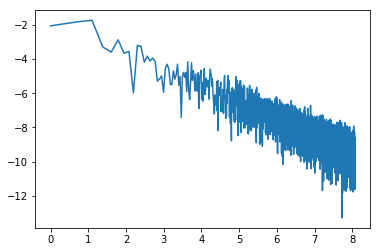

0.0009530273317196763
[0.00146813 0.01723209 0.00714001 0.00706589 0.0170031  0.0014289
 0.01630945 0.08329431 0.04984354 0.04908966 0.08214749 0.01624681
 0.00625997 0.04620871 0.02279874 0.02251485 0.04557539 0.0061227
 0.00612253 0.04620288 0.0228423  0.02267849 0.04586436 0.00613012
 0.01647641 0.0838524  0.04999829 0.04962261 0.0836399  0.01652891
 0.00147558 0.01745357 0.00713715 0.00714017 0.01758983 0.00149476]
169012197


In [62]:
#Re-order the computations here to see how the number of runs affects the fluctuations. Average the points for time i at each run 
#from the same start point, and make a sequence of those. Also, get more than 2 runs starting from each well. 

J=36
#This cell is for testing the data from the un-stratified algorithm
n_hist = 200
n_runs = 16
n_hist_tot = 3200 
G_sum = np.zeros((n_hist_tot,36,36))
G_avg = np.zeros((n_hist_tot,36,36))

test_fcn_nu_sum_un_strat = np.zeros((n_hist_tot,3))
test_fcn_nu_avg_un_strat = np.zeros((n_hist_tot,3))
test_fcn_nu_un_strat_one_stratum_sum = np.zeros((n_hist_tot, J, 3))
test_fcn_nu_un_strat_one_stratum_avg = np.zeros((n_hist_tot, J, 3))

n_points_un_strat = 0
nu_points = un_stratified_data[1][1]
n_points = 0
test_fcn_un_strat_current = np.zeros(3)
test_fcn_un_strat_current_one_stratum = np.zeros((J,3))
for j in xrange(J):
    n_points += len(nu_points[j])
    n_points_un_strat += n_points
    n_points_current_j = len(nu_points[j])
    for l in xrange(len(nu_points[j])):
        test_fcn_un_strat_current += test_function_values(coef_1, coef_2, coef_3, nu_points[j][l])
        test_fcn_un_strat_current_one_stratum[j] += (1. / n_points_current_j) * test_function_values(coef_1, coef_2, coef_3, nu_points[j][l])
        test_fcn_un_strat_current = (1. / n_points) * test_fcn_un_strat_current
test_fcn_nu_un_strat_one_stratum_sum[0] = test_fcn_un_strat_current_one_stratum
test_fcn_nu_un_strat_one_stratum_avg[0] = test_fcn_nu_un_strat_one_stratum_sum[0]

test_fcn_nu_sum_un_strat[0] = test_fcn_un_strat_current
test_fcn_nu_avg_un_strat[0] = test_fcn_nu_sum_un_strat[0]

G_sum[0] = np.array(un_stratified_data[1][0])
G_avg[0] = G_sum[0]


for i in xrange(n_hist_tot-1):
    print i
    
    nu_points = un_stratified_data[i+2][1]
    n_points = 0
    test_fcn_un_strat_current = np.zeros(3)
    for j in xrange(J):
        n_points += len(nu_points[j])
        n_points_un_strat += n_points
        n_points_current_j = len(nu_points[j])
        for l in xrange(len(nu_points[j])):
            test_fcn_un_strat_current += test_function_values(coef_1, coef_2, coef_3, nu_points[j][l])
            test_fcn_un_strat_current_one_stratum[j] += (1. / n_points_current_j) * test_function_values(coef_1, coef_2, coef_3, nu_points[j][l])
    test_fcn_nu_un_strat_one_stratum_sum[i+1] = test_fcn_nu_un_strat_one_stratum_sum[i] + test_fcn_un_strat_current_one_stratum
    test_fcn_nu_un_strat_one_stratum_avg[i+1] = test_fcn_nu_un_strat_one_stratum_sum[i+1] / (i+2.)    
            
    test_fcn_un_strat_current = (1. / n_points) * test_fcn_un_strat_current
    test_fcn_nu_sum_un_strat[i+1] = test_fcn_nu_sum_un_strat[i] + test_fcn_un_strat_current
    test_fcn_nu_avg_un_strat[i+1] = test_fcn_nu_sum_un_strat[i+1] / (i + 2.)
        
    G_sum[i+1] = G_sum[i] + np.array(un_stratified_data[i+2][0])
    G_avg[i+1] = G_sum[i+1] / (i + 2.)
#plt.plot(np.log(xrange(n_hist_tot-1)), [np.log(np.sum(abs(test_avg_un_strat[i+1] - test_avg_un_strat[i]))) for i in xrange(n_hist_tot-1)])
plt.plot(np.log(xrange(n_hist_tot-1)), [np.log(np.sum(abs(test_fcn_nu_avg_un_strat[i+1] - test_fcn_nu_avg_un_strat[i]))) for i in xrange(n_hist_tot-1)])
plt.show()
print test_fcn_nu_avg_un_strat[n_hist_tot-1][0]
for i in xrange(36):
    G_avg[n_hist_tot-1][i] = G_avg[n_hist_tot-1][i] / np.sum(G_avg[n_hist_tot-1][i])
weights_true = np.dot(np.ones(36),np.linalg.matrix_power(G_avg[n_hist_tot-1],2000))
weights_true = weights_true / (np.sum(weights_true))
print weights_true
print n_points_un_strat

#Create the sequence of measures for each run started in a well. Create 16 i-i+1 curves.
#Average the 16 runs at each i. 
#Calculate the variance (of the 16 values of the test functions at time i) at each time i. 
#Try above, but with the 4 averages over all the runs in a well. 
#Check if a run visits each well, and try just doing one long run, instead of re-starting. 
#Try making a histogram of the test function values, and plotting tv distance. 

In [7]:
#f.close()
with open("L96_2D_Strata_Test_Functions_05_27_only_eig.dat", "rb") as f:
    stratified_data_2D_J_comparison = pickle.load(f)
n_iterations = 1000
#h=0.005 (constant), J_range = [16, 36, 64], n_exits = 75, n_iterations = 150

In [172]:
#stratified_data = stratified_data_4_comparison
#stratified_mixed_hist = []
#stratified_mixed_weights = []
#fig = plt.figure()
#ax = Axes3D(fig)

#hist_number = 0      #Indicates which distribution, or joint distribution, is to be extracted from the data
#for m in xrange(300):
    #ax.clear()
#    weights = stratified_data[1][0][2] / (m+1.)
#    hist = stratified_data[0][0][3][0][hist_number] / (m+1.)
#    for i in xrange(m):
#        weights += stratified_data[1][i][2] / (m+1.)
#        hist += stratified_data[0][i+1][3][0][hist_number] / (m+1.)
#    hist = hist / (np.sum(hist) * bin_diff)
#    stratified_mixed_hist.append(hist)
#    stratified_mixed_weights.append(weights)
    
    #ax.plot_surface(bin_edges[1:], bin_edges_later_vars[1:], stratified_mixed_hist[m])
#    plt.plot(bin_edges[1:], stratified_mixed_hist[m],'o')
#    plt.show()
    #raw_input("Press Enter to continue...")

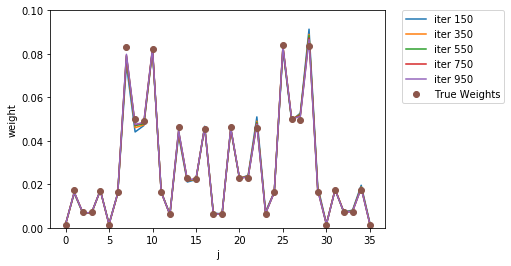

In [63]:
#Comparing the convergence of nu_tot for the basic and eig versions
stratified_data = stratified_data_2D_J_comparison[0]

#weights_sum = (1. / 36.) * np.ones((n_iterations, 36))   #weights_sum[k] will be the sum of the first k weight vectors
weights_sum_eig = (1. / 36.) * np.ones((n_iterations,36))
for k in xrange(n_iterations - 1):
    #weights_sum[k+1] = weights_sum[k] + np.array(stratified_data[2*k][2])
    weights_sum_eig[k+1] = weights_sum_eig[k] + np.array(stratified_data[k+1][2])
#    w=weights/(k+1.)
#    plt.plot(xrange(10), w, 'bo')
#    plt.show()
    
#    raw_input("Press Enter to continue...")

m = 5
for k in xrange(5):
    r =  200 * k +150
    #plt.plot(xrange(64), weights_sum[r] / (r + 1.), label = 'iter ' + str(r))
    plt.plot(xrange(36), weights_sum_eig[r] / (r + 1.), label = 'iter ' + str(r))
    plt.ylim(0.,0.1)
    plt.xlabel('j')
    plt.ylabel('weight')
plt.plot(xrange(36), weights_true, 'o', label='True Weights')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#for k in xrange(50):
#Try: Series of basis functions
#Try: TV distance of histograms
#Try: Indicator functions on strata

#For different J, Try: Plot log(TV-distance), using histograms, as a line with negative slope, with time as the x-axis, and plot the lines for several J on the same graph

plt.show()

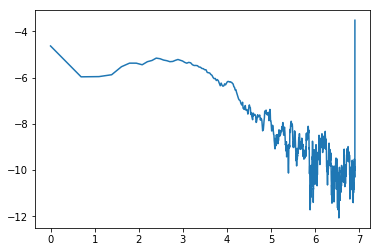

In [79]:
#Plotting tghe evolution of injection measures for stratified vs un-stratified
#For the un-stratified run, the injection measure is the empirical measure of all steps that transition between strata. Other steps are not counted, similar to estimating G in the un-stratified run. 
n_iterations = 1000
K=6
J=36
stratified_data = stratified_data_2D_J_comparison[0]

#Compute the test function averages for the stratified run
test_sum_nu_eig = np.zeros((n_iterations, J, 3))
test_avg_nu_eig = np.zeros((n_iterations, J, 3))
test_nu_eig_un_avg = np.zeros((n_iterations, J, 3))
test_sum_nu_eig_tot = np.zeros((n_iterations, 3))
test_avg_nu_eig_tot = np.zeros((n_iterations, 3))

nu_points_eig = stratified_data[1][0]
nu_probs_eig = stratified_data[1][1]
nu_weights_eig = stratified_data[1][2]
test_fcn_sum_current = np.zeros((J, 3))
test_fcn_sum_current_tot = np.zeros(3)
for j in xrange(J):
    n_points = len(nu_points_eig[j])
    for l in xrange(n_points):
        test_nu_eig_un_avg[0][j] += nu_probs_eig[j][l] * test_function_values(coef_1, coef_2, coef_3, nu_points_eig[j][l])
    test_fcn_sum_current[j] += test_nu_eig_un_avg[0][j]
test_sum_nu_eig[0] = test_fcn_sum_current
test_avg_nu_eig[0] = test_sum_nu_eig[0]
for j in xrange(J):
    test_fcn_sum_current_tot += nu_weights_eig[j] * test_fcn_sum_current[j]
test_sum_nu_eig_tot[0] = test_fcn_sum_current_tot
test_avg_nu_eig_tot[0] = test_sum_nu_eig_tot[0]

for i in xrange(n_iterations - 1):
    nu_points_eig = stratified_data[i+1][0]
    nu_probs_eig = stratified_data[i+1][1]
    nu_weights_eig = stratified_data[i+1][2]
    test_fcn_sum_current = np.zeros((J,3))
    test_fcn_sum_current_tot = np.zeros(3)
    for j in xrange(J):
        n_points = len(nu_points_eig[j])
        for l in xrange(n_points):
            test_nu_eig_un_avg[i+1][j] += nu_probs_eig[j][l] * test_function_values(coef_1, coef_2, coef_3, nu_points_eig[j][l])
        test_fcn_sum_current[j] += test_nu_eig_un_avg[i+1][j]
    for j in xrange(J):
        test_fcn_sum_current_tot += nu_weights_eig[j] * test_fcn_sum_current[j]
    test_sum_nu_eig[i+1] = test_sum_nu_eig[i] + test_fcn_sum_current
    test_avg_nu_eig[i+1] = test_sum_nu_eig[i+1] / (i + 2.)
    test_sum_nu_eig_tot[i+1] = test_sum_nu_eig_tot[i] + test_fcn_sum_current_tot
    test_avg_nu_eig_tot[i+1] = test_sum_nu_eig_tot[i+1] / (i+2.) 
    

plt.plot(np.log(xrange(n_iterations - 1)), [np.log(np.sum(abs(test_avg_nu_eig_tot[i+1] - test_avg_nu_eig_tot[i]))) for i in xrange(n_iterations - 1)])
plt.show()

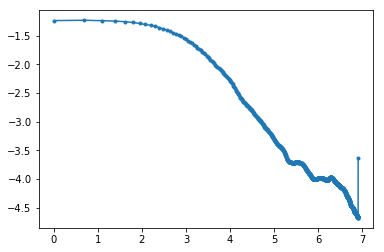

In [96]:
l = 1000
plt.plot(np.log(xrange(l)), [np.log(np.sum(abs(test_avg_nu_eig_tot[k] - test_fcn_nu_avg_un_strat[239]))) for k in xrange(l)], '.-')

In [83]:
#Creating Histograms for the test functions in the stratified and un-stratified runs
stratified_phi_hists = []
bin_edges_phi = np.arange(-3.5, 3.5, 0.02)
bin_diff_phi = 0.02
for s in xrange(3):
    poly_num = s
    H = np.zeros((n_iterations, len(bin_edges_phi)-1))
    for i in xrange(n_iterations):
        print s, i
        nu_weights_eig = stratified_data[i][2]
        for j in xrange(J):
            nu_points_eig = stratified_data[i][0][j]
            nu_probs_eig = stratified_data[i][1][j]
            n_points = len(nu_points_eig)
            for l in xrange(n_points):
                test_value = test_function_values(coef_1, coef_2, coef_3, nu_points_eig[l])[poly_num]
                test_weight = nu_weights_eig[j] * nu_probs_eig[l]
                H[i] = H[i] + np.histogram([test_value], bins=bin_edges_phi, weights=[test_weight])[0]
        H[i] = H[i] / (np.sum(H[i]) * bin_diff_phi)
    stratified_phi_hists.append(H)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


1 402
1 403
1 404
1 405
1 406
1 407
1 408
1 409
1 410
1 411
1 412
1 413
1 414
1 415
1 416
1 417
1 418
1 419
1 420
1 421
1 422
1 423
1 424
1 425
1 426
1 427
1 428
1 429
1 430
1 431
1 432
1 433
1 434
1 435
1 436
1 437
1 438
1 439
1 440
1 441
1 442
1 443
1 444
1 445
1 446
1 447
1 448
1 449
1 450
1 451
1 452
1 453
1 454
1 455
1 456
1 457
1 458
1 459
1 460
1 461
1 462
1 463
1 464
1 465
1 466
1 467
1 468
1 469
1 470
1 471
1 472
1 473
1 474
1 475
1 476
1 477
1 478
1 479
1 480
1 481
1 482
1 483
1 484
1 485
1 486
1 487
1 488
1 489
1 490
1 491
1 492
1 493
1 494
1 495
1 496
1 497
1 498
1 499
1 500
1 501
1 502
1 503
1 504
1 505
1 506
1 507
1 508
1 509
1 510
1 511
1 512
1 513
1 514
1 515
1 516
1 517
1 518
1 519
1 520
1 521
1 522
1 523
1 524
1 525
1 526
1 527
1 528
1 529
1 530
1 531
1 532
1 533
1 534
1 535
1 536
1 537
1 538
1 539
1 540
1 541
1 542
1 543
1 544
1 545
1 546
1 547
1 548
1 549
1 550
1 551
1 552
1 553
1 554
1 555
1 556
1 557
1 558
1 559
1 560
1 561
1 562
1 563
1 564
1 565
1 566
1 567
1 56

2 785
2 786
2 787
2 788
2 789
2 790
2 791
2 792
2 793
2 794
2 795
2 796
2 797
2 798
2 799
2 800
2 801
2 802
2 803
2 804
2 805
2 806
2 807
2 808
2 809
2 810
2 811
2 812
2 813
2 814
2 815
2 816
2 817
2 818
2 819
2 820
2 821
2 822
2 823
2 824
2 825
2 826
2 827
2 828
2 829
2 830
2 831
2 832
2 833
2 834
2 835
2 836
2 837
2 838
2 839
2 840
2 841
2 842
2 843
2 844
2 845
2 846
2 847
2 848
2 849
2 850
2 851
2 852
2 853
2 854
2 855
2 856
2 857
2 858
2 859
2 860
2 861
2 862
2 863
2 864
2 865
2 866
2 867
2 868
2 869
2 870
2 871
2 872
2 873
2 874
2 875
2 876
2 877
2 878
2 879
2 880
2 881
2 882
2 883
2 884
2 885
2 886
2 887
2 888
2 889
2 890
2 891
2 892
2 893
2 894
2 895
2 896
2 897
2 898
2 899
2 900
2 901
2 902
2 903
2 904
2 905
2 906
2 907
2 908
2 909
2 910
2 911
2 912
2 913
2 914
2 915
2 916
2 917
2 918
2 919
2 920
2 921
2 922
2 923
2 924
2 925
2 926
2 927
2 928
2 929
2 930
2 931
2 932
2 933
2 934
2 935
2 936
2 937
2 938
2 939
2 940
2 941
2 942
2 943
2 944
2 945
2 946
2 947
2 948
2 949
2 950
2 95

In [84]:
un_strat_phi_hists = []
bin_edges_phi = np.arange(-3.5, 3.5, 0.02)
bin_diff_phi = 0.02
for s in xrange(3):
    poly_num = s
    H = np.histogram([], bins=bin_edges_phi)[0]
    for i in xrange(n_hist_tot):
        print s, i
        for j in xrange(J):
            nu_points = un_stratified_data[i+1][1][j]
            n_points = len(nu_points)
            for l in xrange(n_points):
                test_value = test_function_values(coef_1, coef_2, coef_3, nu_points[l])[poly_num]
                #test_weight = (1. / n_points) * (1. / J)
                test_weight = (1. / n_points) * weights_true[j]
                H = H + np.histogram([test_value], bins=bin_edges_phi, weights=[test_weight])[0]
    H = H / (np.sum(H) * bin_diff_phi)
    un_strat_phi_hists.append(H)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


0 1329
0 1330
0 1331
0 1332
0 1333
0 1334
0 1335
0 1336
0 1337
0 1338
0 1339
0 1340
0 1341
0 1342
0 1343
0 1344
0 1345
0 1346
0 1347
0 1348
0 1349
0 1350
0 1351
0 1352
0 1353
0 1354
0 1355
0 1356
0 1357
0 1358
0 1359
0 1360
0 1361
0 1362
0 1363
0 1364
0 1365
0 1366
0 1367
0 1368
0 1369
0 1370
0 1371
0 1372
0 1373
0 1374
0 1375
0 1376
0 1377
0 1378
0 1379
0 1380
0 1381
0 1382
0 1383
0 1384
0 1385
0 1386
0 1387
0 1388
0 1389
0 1390
0 1391
0 1392
0 1393
0 1394
0 1395
0 1396
0 1397
0 1398
0 1399
0 1400
0 1401
0 1402
0 1403
0 1404
0 1405
0 1406
0 1407
0 1408
0 1409
0 1410
0 1411
0 1412
0 1413
0 1414
0 1415
0 1416
0 1417
0 1418
0 1419
0 1420
0 1421
0 1422
0 1423
0 1424
0 1425
0 1426
0 1427
0 1428
0 1429
0 1430
0 1431
0 1432
0 1433
0 1434
0 1435
0 1436
0 1437
0 1438
0 1439
0 1440
0 1441
0 1442
0 1443
0 1444
0 1445
0 1446
0 1447
0 1448
0 1449
0 1450
0 1451
0 1452
0 1453
0 1454
0 1455
0 1456
0 1457
0 1458
0 1459
0 1460
0 1461
0 1462
0 1463
0 1464
0 1465
0 1466
0 1467
0 1468
0 1469
0 1470
0 1471

0 2499
0 2500
0 2501
0 2502
0 2503
0 2504
0 2505
0 2506
0 2507
0 2508
0 2509
0 2510
0 2511
0 2512
0 2513
0 2514
0 2515
0 2516
0 2517
0 2518
0 2519
0 2520
0 2521
0 2522
0 2523
0 2524
0 2525
0 2526
0 2527
0 2528
0 2529
0 2530
0 2531
0 2532
0 2533
0 2534
0 2535
0 2536
0 2537
0 2538
0 2539
0 2540
0 2541
0 2542
0 2543
0 2544
0 2545
0 2546
0 2547
0 2548
0 2549
0 2550
0 2551
0 2552
0 2553
0 2554
0 2555
0 2556
0 2557
0 2558
0 2559
0 2560
0 2561
0 2562
0 2563
0 2564
0 2565
0 2566
0 2567
0 2568
0 2569
0 2570
0 2571
0 2572
0 2573
0 2574
0 2575
0 2576
0 2577
0 2578
0 2579
0 2580
0 2581
0 2582
0 2583
0 2584
0 2585
0 2586
0 2587
0 2588
0 2589
0 2590
0 2591
0 2592
0 2593
0 2594
0 2595
0 2596
0 2597
0 2598
0 2599
0 2600
0 2601
0 2602
0 2603
0 2604
0 2605
0 2606
0 2607
0 2608
0 2609
0 2610
0 2611
0 2612
0 2613
0 2614
0 2615
0 2616
0 2617
0 2618
0 2619
0 2620
0 2621
0 2622
0 2623
0 2624
0 2625
0 2626
0 2627
0 2628
0 2629
0 2630
0 2631
0 2632
0 2633
0 2634
0 2635
0 2636
0 2637
0 2638
0 2639
0 2640
0 2641

1 566
1 567
1 568
1 569
1 570
1 571
1 572
1 573
1 574
1 575
1 576
1 577
1 578
1 579
1 580
1 581
1 582
1 583
1 584
1 585
1 586
1 587
1 588
1 589
1 590
1 591
1 592
1 593
1 594
1 595
1 596
1 597
1 598
1 599
1 600
1 601
1 602
1 603
1 604
1 605
1 606
1 607
1 608
1 609
1 610
1 611
1 612
1 613
1 614
1 615
1 616
1 617
1 618
1 619
1 620
1 621
1 622
1 623
1 624
1 625
1 626
1 627
1 628
1 629
1 630
1 631
1 632
1 633
1 634
1 635
1 636
1 637
1 638
1 639
1 640
1 641
1 642
1 643
1 644
1 645
1 646
1 647
1 648
1 649
1 650
1 651
1 652
1 653
1 654
1 655
1 656
1 657
1 658
1 659
1 660
1 661
1 662
1 663
1 664
1 665
1 666
1 667
1 668
1 669
1 670
1 671
1 672
1 673
1 674
1 675
1 676
1 677
1 678
1 679
1 680
1 681
1 682
1 683
1 684
1 685
1 686
1 687
1 688
1 689
1 690
1 691
1 692
1 693
1 694
1 695
1 696
1 697
1 698
1 699
1 700
1 701
1 702
1 703
1 704
1 705
1 706
1 707
1 708
1 709
1 710
1 711
1 712
1 713
1 714
1 715
1 716
1 717
1 718
1 719
1 720
1 721
1 722
1 723
1 724
1 725
1 726
1 727
1 728
1 729
1 730
1 731
1 73

1 1798
1 1799
1 1800
1 1801
1 1802
1 1803
1 1804
1 1805
1 1806
1 1807
1 1808
1 1809
1 1810
1 1811
1 1812
1 1813
1 1814
1 1815
1 1816
1 1817
1 1818
1 1819
1 1820
1 1821
1 1822
1 1823
1 1824
1 1825
1 1826
1 1827
1 1828
1 1829
1 1830
1 1831
1 1832
1 1833
1 1834
1 1835
1 1836
1 1837
1 1838
1 1839
1 1840
1 1841
1 1842
1 1843
1 1844
1 1845
1 1846
1 1847
1 1848
1 1849
1 1850
1 1851
1 1852
1 1853
1 1854
1 1855
1 1856
1 1857
1 1858
1 1859
1 1860
1 1861
1 1862
1 1863
1 1864
1 1865
1 1866
1 1867
1 1868
1 1869
1 1870
1 1871
1 1872
1 1873
1 1874
1 1875
1 1876
1 1877
1 1878
1 1879
1 1880
1 1881
1 1882
1 1883
1 1884
1 1885
1 1886
1 1887
1 1888
1 1889
1 1890
1 1891
1 1892
1 1893
1 1894
1 1895
1 1896
1 1897
1 1898
1 1899
1 1900
1 1901
1 1902
1 1903
1 1904
1 1905
1 1906
1 1907
1 1908
1 1909
1 1910
1 1911
1 1912
1 1913
1 1914
1 1915
1 1916
1 1917
1 1918
1 1919
1 1920
1 1921
1 1922
1 1923
1 1924
1 1925
1 1926
1 1927
1 1928
1 1929
1 1930
1 1931
1 1932
1 1933
1 1934
1 1935
1 1936
1 1937
1 1938
1 1939
1 1940

1 2968
1 2969
1 2970
1 2971
1 2972
1 2973
1 2974
1 2975
1 2976
1 2977
1 2978
1 2979
1 2980
1 2981
1 2982
1 2983
1 2984
1 2985
1 2986
1 2987
1 2988
1 2989
1 2990
1 2991
1 2992
1 2993
1 2994
1 2995
1 2996
1 2997
1 2998
1 2999
1 3000
1 3001
1 3002
1 3003
1 3004
1 3005
1 3006
1 3007
1 3008
1 3009
1 3010
1 3011
1 3012
1 3013
1 3014
1 3015
1 3016
1 3017
1 3018
1 3019
1 3020
1 3021
1 3022
1 3023
1 3024
1 3025
1 3026
1 3027
1 3028
1 3029
1 3030
1 3031
1 3032
1 3033
1 3034
1 3035
1 3036
1 3037
1 3038
1 3039
1 3040
1 3041
1 3042
1 3043
1 3044
1 3045
1 3046
1 3047
1 3048
1 3049
1 3050
1 3051
1 3052
1 3053
1 3054
1 3055
1 3056
1 3057
1 3058
1 3059
1 3060
1 3061
1 3062
1 3063
1 3064
1 3065
1 3066
1 3067
1 3068
1 3069
1 3070
1 3071
1 3072
1 3073
1 3074
1 3075
1 3076
1 3077
1 3078
1 3079
1 3080
1 3081
1 3082
1 3083
1 3084
1 3085
1 3086
1 3087
1 3088
1 3089
1 3090
1 3091
1 3092
1 3093
1 3094
1 3095
1 3096
1 3097
1 3098
1 3099
1 3100
1 3101
1 3102
1 3103
1 3104
1 3105
1 3106
1 3107
1 3108
1 3109
1 3110

2 1097
2 1098
2 1099
2 1100
2 1101
2 1102
2 1103
2 1104
2 1105
2 1106
2 1107
2 1108
2 1109
2 1110
2 1111
2 1112
2 1113
2 1114
2 1115
2 1116
2 1117
2 1118
2 1119
2 1120
2 1121
2 1122
2 1123
2 1124
2 1125
2 1126
2 1127
2 1128
2 1129
2 1130
2 1131
2 1132
2 1133
2 1134
2 1135
2 1136
2 1137
2 1138
2 1139
2 1140
2 1141
2 1142
2 1143
2 1144
2 1145
2 1146
2 1147
2 1148
2 1149
2 1150
2 1151
2 1152
2 1153
2 1154
2 1155
2 1156
2 1157
2 1158
2 1159
2 1160
2 1161
2 1162
2 1163
2 1164
2 1165
2 1166
2 1167
2 1168
2 1169
2 1170
2 1171
2 1172
2 1173
2 1174
2 1175
2 1176
2 1177
2 1178
2 1179
2 1180
2 1181
2 1182
2 1183
2 1184
2 1185
2 1186
2 1187
2 1188
2 1189
2 1190
2 1191
2 1192
2 1193
2 1194
2 1195
2 1196
2 1197
2 1198
2 1199
2 1200
2 1201
2 1202
2 1203
2 1204
2 1205
2 1206
2 1207
2 1208
2 1209
2 1210
2 1211
2 1212
2 1213
2 1214
2 1215
2 1216
2 1217
2 1218
2 1219
2 1220
2 1221
2 1222
2 1223
2 1224
2 1225
2 1226
2 1227
2 1228
2 1229
2 1230
2 1231
2 1232
2 1233
2 1234
2 1235
2 1236
2 1237
2 1238
2 1239

2 2267
2 2268
2 2269
2 2270
2 2271
2 2272
2 2273
2 2274
2 2275
2 2276
2 2277
2 2278
2 2279
2 2280
2 2281
2 2282
2 2283
2 2284
2 2285
2 2286
2 2287
2 2288
2 2289
2 2290
2 2291
2 2292
2 2293
2 2294
2 2295
2 2296
2 2297
2 2298
2 2299
2 2300
2 2301
2 2302
2 2303
2 2304
2 2305
2 2306
2 2307
2 2308
2 2309
2 2310
2 2311
2 2312
2 2313
2 2314
2 2315
2 2316
2 2317
2 2318
2 2319
2 2320
2 2321
2 2322
2 2323
2 2324
2 2325
2 2326
2 2327
2 2328
2 2329
2 2330
2 2331
2 2332
2 2333
2 2334
2 2335
2 2336
2 2337
2 2338
2 2339
2 2340
2 2341
2 2342
2 2343
2 2344
2 2345
2 2346
2 2347
2 2348
2 2349
2 2350
2 2351
2 2352
2 2353
2 2354
2 2355
2 2356
2 2357
2 2358
2 2359
2 2360
2 2361
2 2362
2 2363
2 2364
2 2365
2 2366
2 2367
2 2368
2 2369
2 2370
2 2371
2 2372
2 2373
2 2374
2 2375
2 2376
2 2377
2 2378
2 2379
2 2380
2 2381
2 2382
2 2383
2 2384
2 2385
2 2386
2 2387
2 2388
2 2389
2 2390
2 2391
2 2392
2 2393
2 2394
2 2395
2 2396
2 2397
2 2398
2 2399
2 2400
2 2401
2 2402
2 2403
2 2404
2 2405
2 2406
2 2407
2 2408
2 2409

In [85]:
#Create Average Histograms
strat_phi_hists_avg = []
for s in xrange(3):
    H = stratified_phi_hists[s]
    for i in xrange(n_iterations - 1):
        H[i+1] = H[i+1] + H[i]
    for i in xrange(n_iterations):
        H[i] = H[i] / (np.sum(H[i]) * bin_diff_phi)
    strat_phi_hists_avg.append(H)

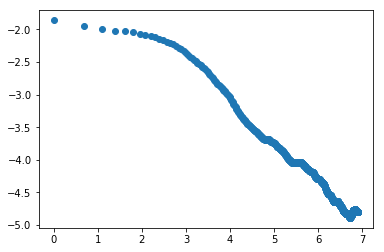

In [97]:
s=2
plt.plot(np.log(xrange(n_iterations)), [np.log(TV_dist(un_strat_phi_hists[s], strat_phi_hists_avg[s][i], bin_diff_phi)) for i in xrange(n_iterations)], 'o')
plt.show()

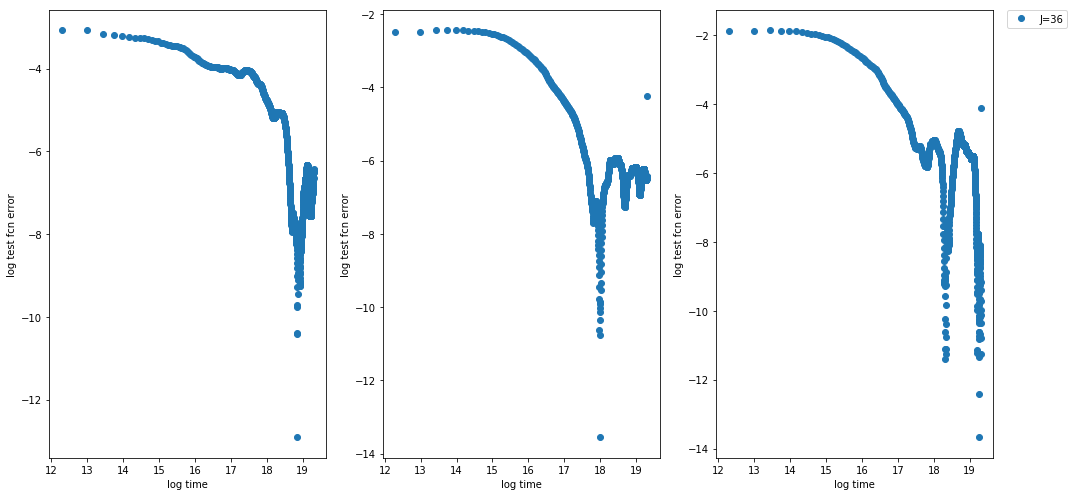

In [81]:
#This cell generates a graph for comparing performance across different values of J. 
iter_times = np.zeros(n_iterations)
iter_times_eig = np.zeros(n_iterations)
plt.figure(figsize = (15,7))

J = 36
stratified_data = stratified_data_2D_J_comparison[0]
for poly_num in xrange(3):
    
    iter_times[0] = np.amax(np.array(stratified_data[0][3]))
    iter_times_eig[0] = np.amax(np.array(stratified_data[1][3]))
    for k in xrange(n_iterations - 1):
        #iter_times[k+1] = iter_times[k] + np.amax(np.array(stratified_data[2*k][3]))
        iter_times_eig[k+1] = iter_times_eig[k] + np.amax(np.array(stratified_data[k+1][3]))
    
    m = 1
    l = 1000
    #plt.plot(np.log(iter_times[:l]), [np.log(abs(test_avg[k] - test_avg_un_strat[1199][3 * poly_num])) for k in xrange(l)], 'o', label = 'J=' + str(J))
    plt.subplot(1, 3, poly_num+1)
    plt.plot(np.log(iter_times_eig[:l]), [np.log(abs(test_avg_nu_eig_tot[k][poly_num] - test_avg_un_strat[239][poly_num])) for k in xrange(l)], 'o', label = 'J=' + str(J))
    plt.xlabel('log time')
    plt.ylabel('log test fcn error') 
#Note: Run un-stratified again, but without re-starting at x_0 every 200 times, so that it is just the trajectory of a single particle

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

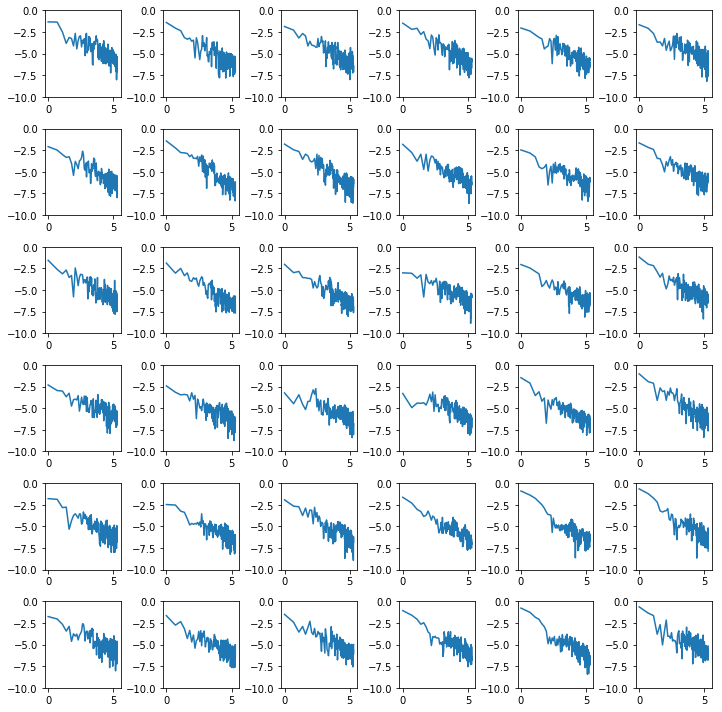

In [21]:
K=6
s=200
plt.figure(figsize = (10,10))
for l in xrange(K):
    for k in xrange(K):
        j = l * K + k
    
        plt.subplot(K,K,j+1)
        #plt.figure(figsize = (10,10))
        plt.ylim(-10., 0.)
        plt.plot(np.log(xrange(s)), [np.log(np.sum(abs(test_avg_nu_eig[i+1][j] - test_avg_nu_eig[i][j]))) for i in xrange(s)])
        #plt.plot(np.log(xrange(n_iterations - 1)), [np.log(np.sum(abs(test_nu_eig_un_avg[i+1][j] - test_nu_eig_un_avg[i][j]))) for i in xrange(n_iterations - 1)])
plt.tight_layout()
#plt.show()

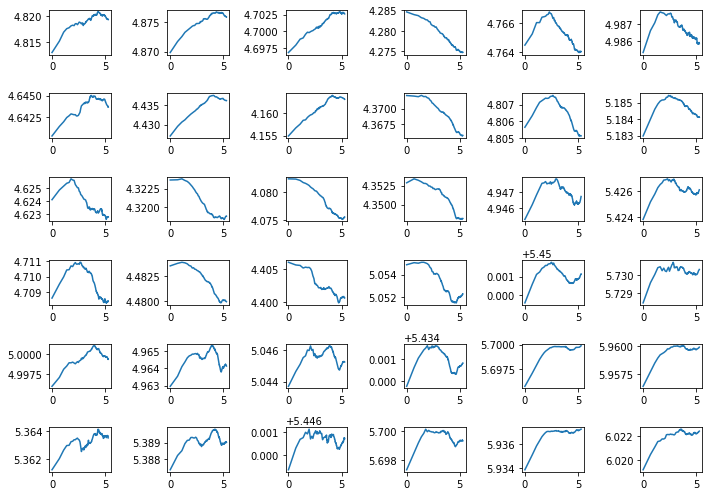

In [22]:
#Plot the non-time-averaged weights on each stratum

#Look into why the first iteration time seems so large
s=200
plt.figure(figsize = (10,7))
for l in xrange(K):
    for k in xrange(K):
        j = l * K + k
    
        plt.subplot(K,K,j+1)
        #plt.figure(figsize = (10,10))
        #plt.ylim()
        plt.plot(np.log(xrange(s)), [np.log(np.sum(abs(test_avg_nu_eig[i][j] - test_fcn_nu_un_strat_one_stratum_avg[239][j]))) for i in xrange(s)])
        #plt.plot(np.log(xrange(n_iterations)), [np.log(np.sum(abs(test_nu_eig_un_avg[i][j] - test_fcn_nu_un_strat_one_stratum_avg[239][j]))) for i in xrange(n_iterations)])
plt.tight_layout()
#plt.show()

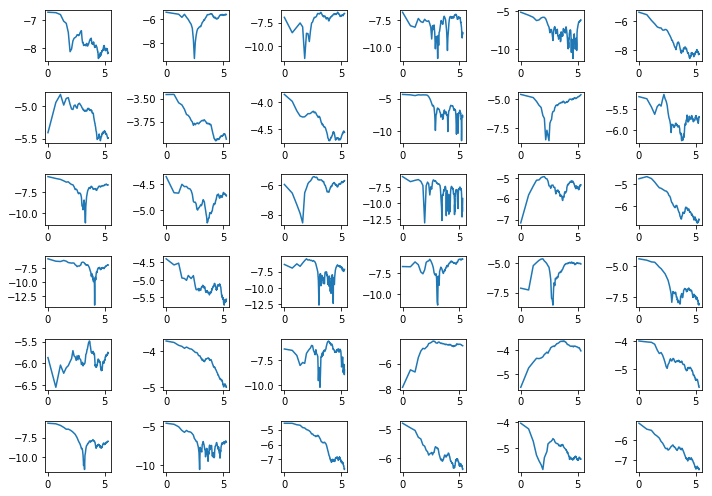

In [23]:
#Compute the un-averaged weights over the run
nu_weights_eig_un_avg = np.zeros((n_iterations, J))
for i in xrange(n_iterations):
    nu_weights_eig_un_avg[i] = np.array(stratified_data[2*i+1][2])
    nu_weights_eig_un_avg[i] = nu_weights_eig_un_avg[i] / (np.sum(nu_weights_eig_un_avg[i]))

#Compute the Averaged Weights over the run
nu_weights_eig_avg = np.zeros((n_iterations, J))
nu_weights_eig_sum = np.zeros(J)
for i in xrange(n_iterations):
    nu_weights_eig_sum += np.array(stratified_data[2*i+1][2])
    nu_weights_eig_avg[i] = nu_weights_eig_sum / (i + 1.)

s=200
plt.figure(figsize = (10,7))
for l in xrange(K):
    for k in xrange(K):
        j = l * K + k
    
        plt.subplot(K,K,j+1)
        #plt.figure(figsize = (10,10))
        #plt.ylim()
        #plt.plot(np.log(xrange(n_iterations)), [np.log(abs(nu_weights_eig_un_avg[i][j] - weights_true[j])) for i in xrange(n_iterations)])
        plt.plot(np.log(xrange(s)), [np.log(abs(nu_weights_eig_avg[i][j] - weights_true[j])) for i in xrange(s)])
plt.tight_layout()
#plt.show()

In [53]:
print len(un_stratified_data)

3201


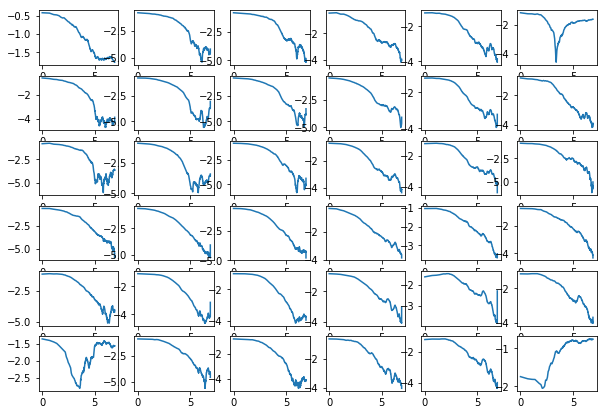

In [56]:
#Create the injection measure in just A_0, averaged to time i, for both stratified and un-stratified data
phi_sum_eig = np.zeros((J , n_iterations, 3))
phi_sum_un_strat= np.zeros((J, 3200, 3))
plt.figure(figsize = (10,7))
for s in xrange(6):
    for t in xrange(6):
        j = 6 * s + t

        nu_points = un_stratified_data[1][1][j]
        n_points = len(nu_points)
        for k in xrange(n_points):
            phi_sum_un_strat[j][0] += (1. / n_points) * np.array(test_function_values(coef_1, coef_2, coef_3, nu_points[k]))

        nu_points_eig = stratified_data[0][0][j]
        nu_probs_eig = stratified_data[0][1][j]
        n_points_eig = len(nu_points_eig)
        for k in xrange(n_points_eig):
            phi_sum_eig[j][0] += nu_probs_eig[k] * np.array(test_function_values(coef_1, coef_2, coef_3, nu_points_eig[k]))

        for i in xrange(3199):
            nu_points = un_stratified_data[i+2][1][j]
            n_points = len(nu_points)
            for k in xrange(n_points):
                phi_sum_un_strat[j][i+1] += (1. / n_points) * np.array(test_function_values(coef_1, coef_2, coef_3, nu_points[k]))
            phi_sum_un_strat[j][i+1] = phi_sum_un_strat[j][i] + phi_sum_un_strat[j][i+1]

        for i in xrange(999):
            nu_points_eig = stratified_data[i+1][0][j]
            nu_probs_eig = stratified_data[i+1][1][j]
            n_points_eig = len(nu_points_eig)
            for k in xrange(n_points_eig):
                phi_sum_eig[j][i+1] += nu_probs_eig[k] * np.array(test_function_values(coef_1, coef_2, coef_3, nu_points_eig[k]))
            phi_sum_eig[j][i+1] = phi_sum_eig[j][i] + phi_sum_eig[j][i+1]

        plt.subplot(6,6,j+1)
        plt.plot(np.log(xrange(1000)), [np.log(np.sum(abs(phi_sum_eig[j][i]/(i+1.) - phi_sum_un_strat[j][3199]/(3200.)))) for i in xrange(1000)], '-')
        #plt.plot(np.log(xrange(3199)), [np.log(np.sum(abs(phi_sum_un_strat[i]/(i+1.) - phi_sum_un_strat[i+1]/(i+2.)))) for i in xrange(3199)], '-')
plt.show()

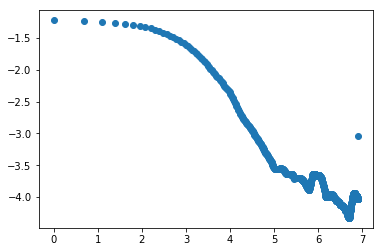

In [73]:
phi_avg_eig_tot = np.zeros((n_iterations, 3))
phi_avg_un_strat_tot = np.zeros(3)

for i in xrange(n_iterations):
    for j in xrange(J):
        phi_avg_eig_tot[i] += weights_sum_eig[i][j]/ (i+1.) * np.array(phi_sum_eig[j][i] / (i+1.))

for j in xrange(J):
    phi_avg_un_strat_tot += weights_true[j] * np.array(phi_sum_un_strat[j][3199] / (3200.))

plt.plot(np.log(xrange(n_iterations)), [np.log(np.sum(abs(phi_avg_eig_tot[i] - phi_avg_un_strat_tot))) for i in xrange(n_iterations)], 'o')
plt.show()

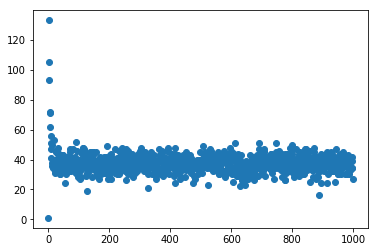

In [20]:
min_points = [np.amin(n_exits_in_eig[i]) for i in xrange(n_iterations)]
plt.plot(xrange(n_iterations), min_points, 'o')

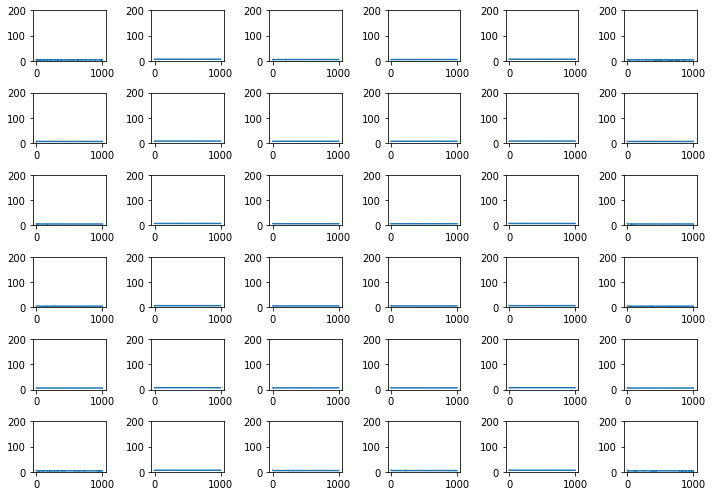

In [19]:
#Plot heat maps in some well converging strata and some"problem" strata
#Plot the number of exits into each stratum over time

n_exits_in_eig = np.zeros((n_iterations, J))
for i in xrange(n_iterations):
    nu_points = stratified_data[i][0]
    for j in xrange(J):
        n_exits_in_eig[i][j] = len(nu_points[j])

plt.figure(figsize = (10,7))
for l in xrange(K):
    for k in xrange(K):
        j = l * K + k
    
        plt.subplot(K,K,j+1)
        plt.ylim(0., 200.)
        plt.plot(xrange(n_iterations), [np.log(n_exits_in_eig[i][j]) for i in xrange(n_iterations)])
plt.tight_layout()
#plt.show()

In [ ]:
Hypothesis: At time somes, strata either have no exits into them or have exits only from some directions, so the corresponding injection measures are distorted. 

In [189]:
#Make a graph showing minimum numbers of exits between strata, to identify dips. 

#Grid with exits from A_j into A_k at time i
n_exits_grid_eig = np.zeros((n_iterations,J,J))



In [ ]:
#Make a movie showing a grid with numbers of exits between strata at each time. 

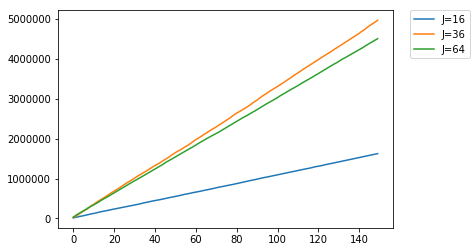

In [230]:
for j in xrange(3):
    J = (4 + 2*j)**2
    #plt.plot(xrange(150), iter_times[j], label = 'J=' + str(J))
    plt.plot(xrange(150), iter_times_eig[j], label = 'J=' + str(J))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [94]:
#weights = [.125, .125, .125, .125, .125, .125, .125, .125]
#for m in xrange(300):
#    weights += stratified_data[1][m][2] 
#    w=weights/(m+1.)
#    plt.plot(xrange(8), w, 'o')
#    plt.show()
#    
#    raw_input("Press Enter to continue...")

In [8]:
#This cell is for testing the creating of a movie with moviepy.editor.VideoClip and a make_frame function
#note: t ranges from 0 to duration, in increments of 1/fps. Make sure that it lines up with the number of plots to be used,
#So that you can call a new iteration of the algorithm for each new frame. E.g. here, duration = 3 and fps=10, and t_range
#has 30 values, so the video goes through all 30 plots in 3 seconds. 
t_range = np.arange(0.0, 3.0, 0.1)

duration = 3
fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    x = bin_edges[1:]
    t_current = t_range[int(t * 10)]
    ax.plot(x, t_current * x**2, 'o')
    ax.set_ylim(0.0, 3.0)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=int(len(t_range) / duration), loop=True, autoplay=True)

Text(0.5,0,'z')

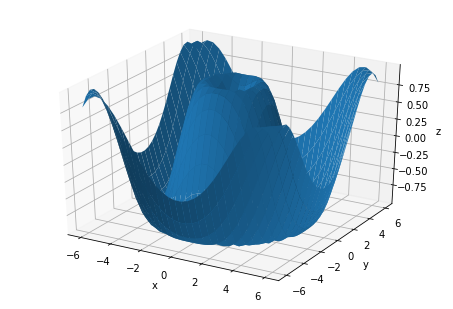

In [2]:
#Test for 3d plotting
fig = plt.figure()

ax = Axes3D(fig)
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)
ax.plot_surface(X, Y, Z)
#ax.scatter(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


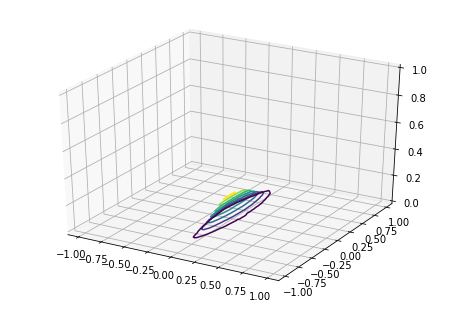

In [13]:
#Create video of 3d plots from the stratified data
#Joint Distribution of X_0, X_1 for 4 noise

duration = 29.9
#fig, ax = plt.subplots()
fig = plt.figure()
ax = Axes3D(fig)
def make_frame(t):
    ax.clear()
    m = int(t * 10)
    ax.contour3D(bin_edges[1:], bin_edges[1:], stratified_mixed_hist[m])
    #ax.plot(bin_edges[1:], stratified_mixed_hist[m], 'o')
    ax.set_zlim(0.0, 1.0)
    #ax.set_ylim(0.0, 1.7)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=10, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4




t:  90%|████████▉ | 268/299 [00:32<00:03,  9.15it/s, now=None]


t: 100%|██████████| 299/299 [00:36<00:00,  8.61it/s, now=None]
                                                              

Moviepy - Done !
Moviepy - video ready __temp__.mp4


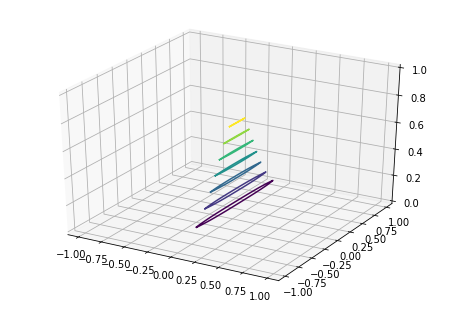

In [90]:
#Create video of 3d plots from the stratified data
#Joint Distribution of X_0, X_19 for 4 noise

duration = 29.9
#fig, ax = plt.subplots()
fig = plt.figure()
ax = Axes3D(fig)
def make_frame(t):
    ax.clear()
    m = int(t * 10)
    ax.contour3D(bin_edges[1:], bin_edges[1:], stratified_mixed_hist[m])
    #ax.plot(bin_edges[1:], stratified_mixed_hist[m], 'o')
    ax.set_zlim(0.0, 1.0)
    #ax.set_ylim(0.0, 1.7)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=10, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4




t:  88%|████████▊ | 262/299 [00:34<00:04,  8.35it/s, now=None]


t: 100%|██████████| 299/299 [00:38<00:00,  8.75it/s, now=None]
                                                              

Moviepy - Done !
Moviepy - video ready __temp__.mp4


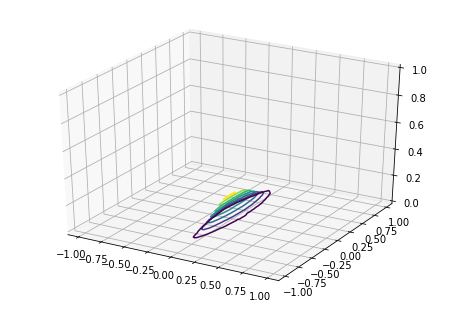

In [96]:
#Joint Distribution of X_0, X_4 for 4 noise

duration = 29.9
#fig, ax = plt.subplots()
fig = plt.figure()
ax = Axes3D(fig)
def make_frame(t):
    ax.clear()
    m = int(t * 10)
    ax.contour3D(bin_edges[1:], bin_edges[1:], stratified_mixed_hist[m])
    #ax.plot(bin_edges[1:], stratified_mixed_hist[m], 'o')
    ax.set_zlim(0.0, 1.0)
    #ax.set_ylim(0.0, 1.7)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=10, loop=True, autoplay=True)

In [16]:
np.array([2.,3.])/np.array([1.,2.])

array([2. , 1.5])